## Creating the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

# path to store/load data
path2data="/content/drive/MyDrive/Chapter 9/data"
os.makedirs(path2data, exist_ok= True)
    

h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform= transforms.Compose([
           transforms.Resize((h,w)),
           transforms.CenterCrop((h,w)),
           transforms.ToTensor(),
           transforms.Normalize(mean, std)])
    
train_ds=datasets.STL10(path2data, split='train', 
                        download=True,
                        transform=transform)
print(len(train_ds))

Files already downloaded and verified
5000


In [ ]:
import torch
for x, _ in train_ds:
    print(x.shape, torch.min(x), torch.max(x))
    break

torch.Size([3, 64, 64]) tensor(-0.8980) tensor(0.9529)


In [ ]:
import torch

for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 64, 64]) 1


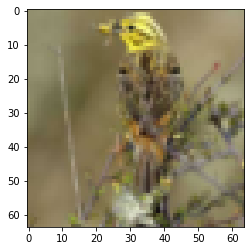

In [ ]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(to_pil_image(0.5*x+0.5))

In [ ]:
import torch

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True)

In [ ]:
for x,y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])


## Defining Generator

In [ ]:
from torch import nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        nz = params["nz"]
        ngf = params["ngf"]
        noc = params["noc"]
        self.dconv1 = nn.ConvTranspose2d( nz, ngf * 8, kernel_size=4,
                                         stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.dconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.dconv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.dconv4 = nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d( ngf, noc, kernel_size=4, 
                                         stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))            
        x = F.relu(self.bn3(self.dconv3(x)))        
        x = F.relu(self.bn4(self.dconv4(x)))    
        out = torch.tanh(self.dconv5(x))
        return out

In [ ]:
params_gen = {
        "nz": 100,
        "ngf": 64,
        "noc": 3,
        }
model_gen = Generator(params_gen)
#device = torch.device("cuda:3")
#model_gen.to(device)
print(model_gen)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [ ]:
with torch.no_grad():
    y= model_gen(torch.zeros(1,100,1,1))
print(y.shape)    

torch.Size([1, 3, 64, 64])


## Defining Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super(Discriminator, self).__init__()
        nic= params["nic"]
        ndf = params["ndf"]
        self.conv1 = nn.Conv2d(nic, ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)            
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace = True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace = True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace = True)        
        
        out = torch.sigmoid(self.conv5(x))
        return out.view(-1)

In [ ]:
params_dis = {
    "nic": 3,
    "ndf": 64}
model_dis = Discriminator(params_dis)
#model_dis.to(device)
print(model_dis)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [ ]:
with torch.no_grad():
    y= model_dis(torch.zeros(1,3,h,w))
print(y.shape)    

torch.Size([1])


In [ ]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

## Defining Loss, Optimizer

In [ ]:
loss_func = nn.BCELoss()

In [ ]:
from torch import optim

lr = 2e-4 
beta1 = 0.5
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [ ]:
real_label = 1
fake_label = 0
nz = params_gen["nz"]
num_epochs = 5


loss_history={"gen": [],
              "dis": []}

batch_count = 0
for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)
        model_dis.zero_grad()
        yb = torch.full((ba_si,), real_label)
        yb = yb.float()
        out_dis = model_dis(xb)
        loss_r = loss_func(out_dis, yb)
        loss_r.backward()

        noise = torch.randn(ba_si, nz, 1, 1)
        out_gen = model_gen(noise)
        out_dis = model_dis(out_gen.detach())
        yb.fill_(fake_label)    
        loss_f = loss_func(out_dis, yb)
        loss_f.backward()
        loss_dis = loss_r + loss_f  
        opt_dis.step()   

        model_gen.zero_grad()
        yb.fill_(real_label)  
        out_dis = model_dis(out_gen)
        loss_gen = loss_func(out_dis, yb)
        loss_gen.backward()
        opt_gen.step()

        loss_history["gen"].append(loss_gen.item())
        loss_history["dis"].append(loss_dis.item())
        batch_count += 1
        if batch_count % 100 == 0:
            print(epoch, loss_gen.item(),loss_dis.item())
        

0 6.389103412628174 0.5597583651542664
1 5.280320167541504 0.7981064319610596
1 4.949190139770508 0.33829787373542786
2 6.4450178146362305 0.16123703122138977
3 8.443227767944336 0.8471227884292603
3 4.185265064239502 0.34579336643218994
4 5.484264373779297 0.26554206013679504


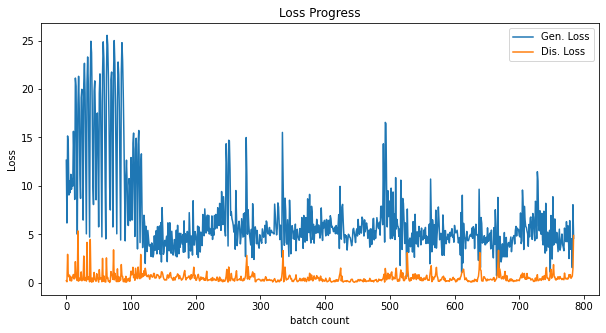

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss Progress")
plt.plot(loss_history["gen"],label="Gen. Loss")
plt.plot(loss_history["dis"],label="Dis. Loss")
plt.xlabel("batch count")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# store models
import os
path2models = "/content/drive/MyDrive/Chapter 9/models/"
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, "weights_gen_128.pt")
path2weights_dis = os.path.join(path2models, "weights_dis_128.pt")

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

## Deploying Generator

In [ ]:
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)
model_gen.eval()

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

torch.Size([16, 100, 1, 1])
torch.Size([16, 3, 64, 64])


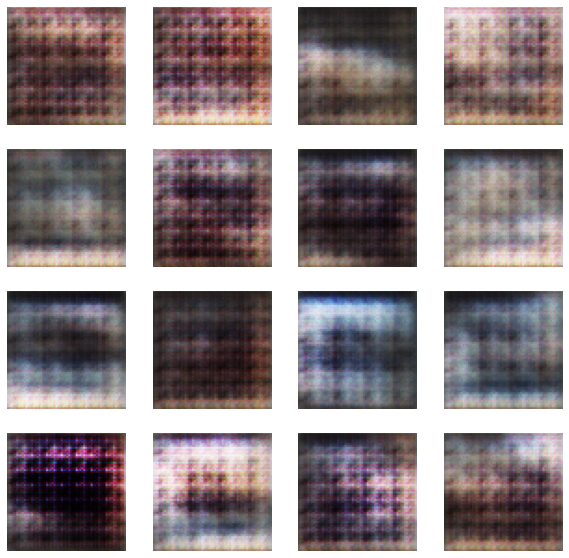

In [ ]:
import numpy as np

with torch.no_grad():
    fixed_noise = torch.randn(16, nz, 1, 1)
    print(fixed_noise.shape)
    img_fake = model_gen(fixed_noise).detach().cpu()    
print(img_fake.shape)

plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5))
    plt.axis("off")
    